#Group3_Data_Operations

In [1]:
# %pip install jupyter-black

In [2]:
# @title Import relevant modules
import os
import sys
import pandas as pd
import geopandas as gpd # type: ignore
import sqlalchemy as sq
import black
import jupyter_black as bl # type: ignore
from matplotlib import pyplot as plt # type: ignore
from dotenv import load_dotenv
from Shared.DataService import DataService


/usr/local/lib/python3.8/dist-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/tmp/ipykernel_72990/3288592410.py:5: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling

In [3]:
# The following lines adjust the granularity of reporting.
pd.options.display.max_rows = 100
pd.options.display.float_format = "{:.1f}".format
pd.set_option("display.max_columns", None)

In [4]:
os.chdir("../../src")
bl.load()
load_dotenv("docker/.env")
PG_USER = os.getenv("POSTGRES_USER")
PG_PW = os.getenv("POSTGRES_PW")
PG_DB = os.getenv("POSTGRES_DB")
PG_ADDR = os.getenv("POSTGRES_ADDR")
PG_PORT = os.getenv("POSTGRES_PORT")

if PG_PORT is None:
    sys.exit("Error: Could not find the port for the database.")

In [5]:
regions = "WeatherStation/data/2006CensusAgRegions/gcar000b07a_e.shp"
gdfRegions = gpd.read_file(regions, encoding="utf-8")

In [6]:
stations = "WeatherStation/data/climate_station_list.csv"
dfStations = pd.read_csv(stations)

In [7]:
gdfStationsHly = gpd.GeoDataFrame(
    dfStations, geometry=gpd.points_from_xy(dfStations.Longitude, dfStations.Latitude)
)
gdfStationsHly = gdfStationsHly.loc[dfStations["HLY Last Year"] > 1995]

In [8]:
gdfStationsDly = gpd.GeoDataFrame(
    dfStations, geometry=gpd.points_from_xy(dfStations.Longitude, dfStations.Latitude)
)
gdfStationsDly = gdfStationsDly.loc[dfStations["HLY Last Year"] > 1995]

In [9]:
gdfRegions = gdfRegions.to_crs(crs={"init": "EPSG:3347"})
gdfStationsHly = gdfStationsHly.set_crs("EPSG:4326", allow_override=True)
gdfStationsHly = gdfStationsHly.to_crs("EPSG:3347")
gdfStationsDly = gdfStationsDly.set_crs("EPSG:4326", allow_override=True)
gdfStationsDly = gdfStationsDly.to_crs("EPSG:3347")

/usr/local/lib/python3.8/dist-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


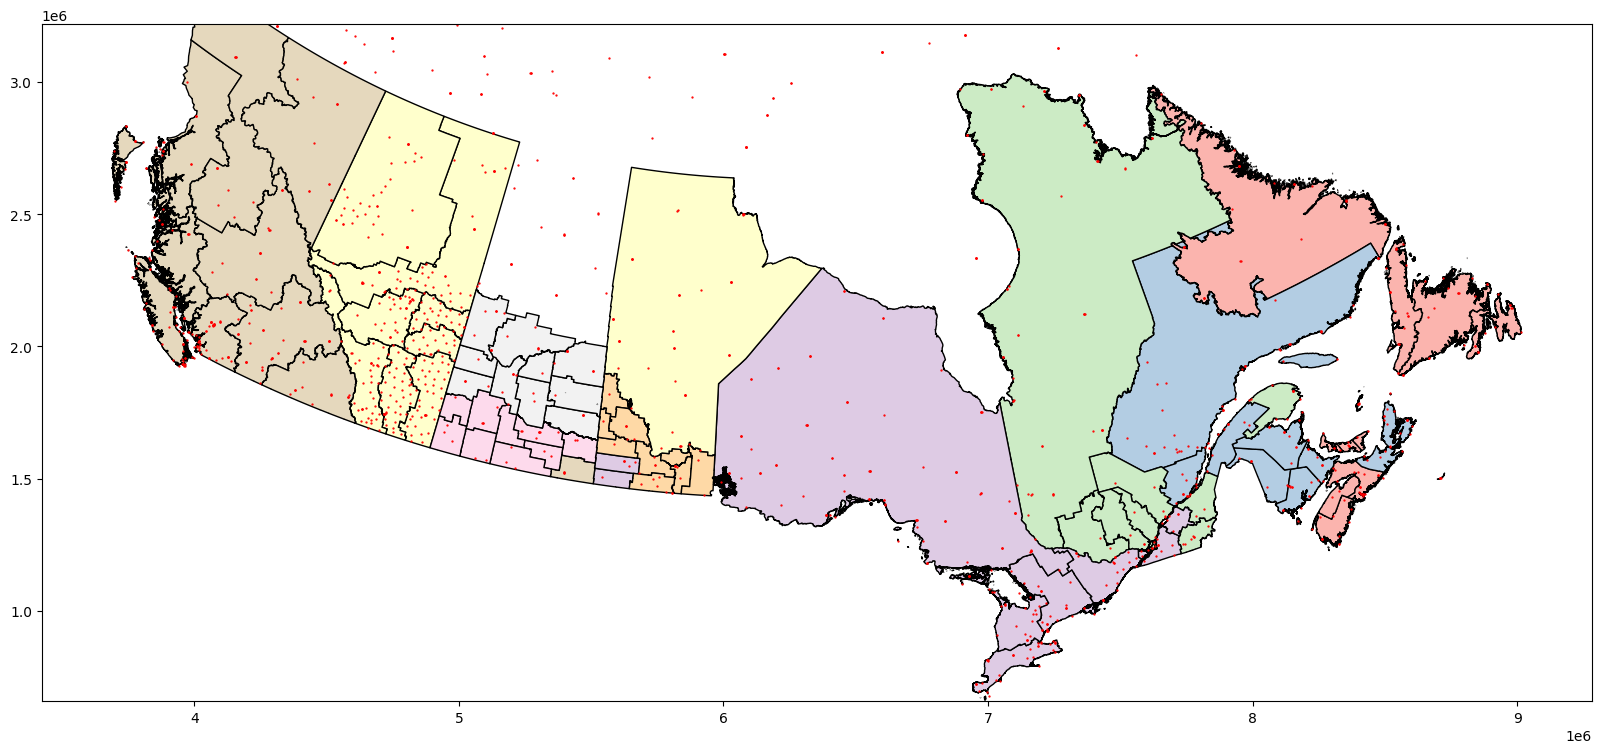

In [10]:
minx, miny, maxx, maxy = gdfRegions.total_bounds
# plot the both
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy / 1.1)
gdfRegions.plot(ax=ax, cmap="Pastel1", edgecolor="black")
gdfStationsHly.plot(ax=ax, color="red", markersize=0.4)
plt.show()

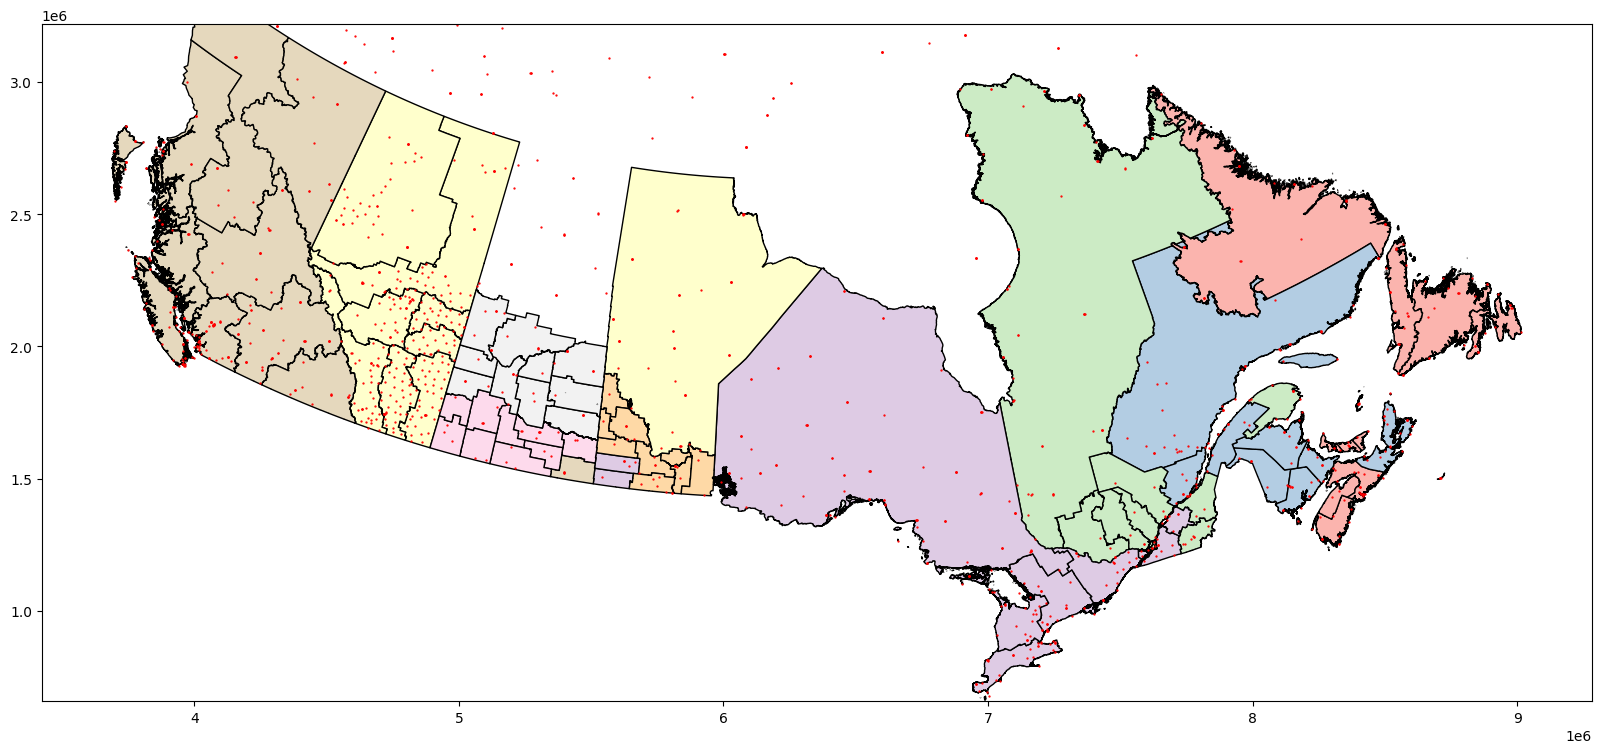

In [11]:
minx, miny, maxx, maxy = gdfRegions.total_bounds
# plot the both
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny, maxy / 1.1)
gdfRegions.plot(ax=ax, cmap="Pastel1", edgecolor="black")
gdfStationsDly.plot(ax=ax, color="red", markersize=0.4)
plt.show()

In [12]:
gdfRegions.head()

,CARuid,CARname,PRuid,AGuid,geometry
0,1001,Census Agricultural Region 1,10,100100000,"MULTIPOLYGON (((8827582.212 1954411.801, 88278..."
1,1002,Census Agricultural Region 2,10,100200000,"MULTIPOLYGON (((8794885.530 1986655.862, 87948..."
2,1003,Census Agricultural Region 3,10,100300000,"MULTIPOLYGON (((8535154.148 1912868.942, 85352..."
3,1101,Census Agricultural Region 1,11,110100000,"MULTIPOLYGON (((8422008.111 1618602.652, 84220..."
4,1102,Census Agricultural Region 2,11,110200000,"MULTIPOLYGON (((8369249.903 1605063.582, 83692..."


In [13]:
# remove rows with nan
gdfPruned = gdfRegions.copy(deep=True)
# keep ab mb sk
gdfPruned["PRuid"] = gdfPruned["PRuid"].astype(int)
gdfPruned = gdfPruned.loc[gdfPruned["PRuid"].isin([46, 47, 48])]

In [14]:
gdfPruned.set_crs("EPSG:4326", allow_override=True)
gdfProjected = gdfPruned.to_crs("EPSG:3347")

<Axes: >

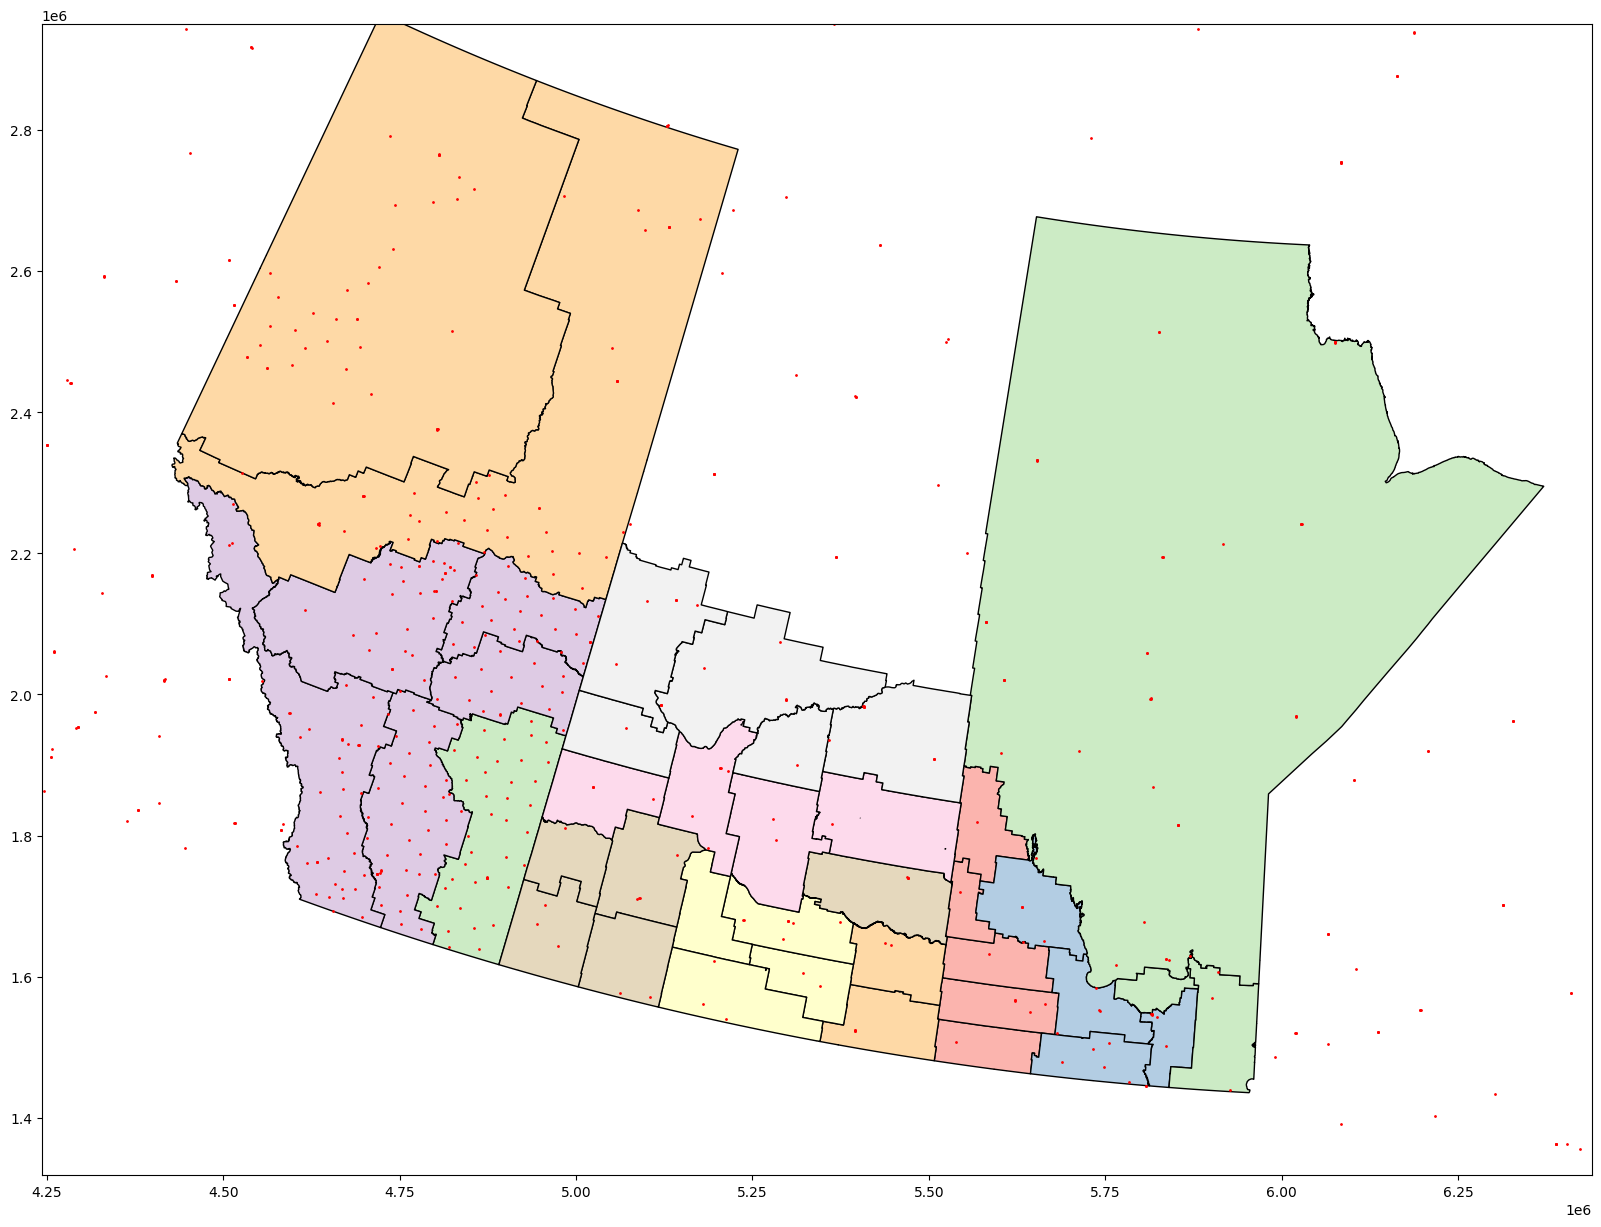

In [15]:
# plot stations vs projected regions
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny * 2, maxy / 1.2)
ax.set_xlim(minx * 1.15, maxx / 1.4)
gdfProjected.plot(ax=ax, cmap="Pastel1", edgecolor="black")
gdfStationsHly.plot(ax=ax, color="red", markersize=1)

<Axes: >

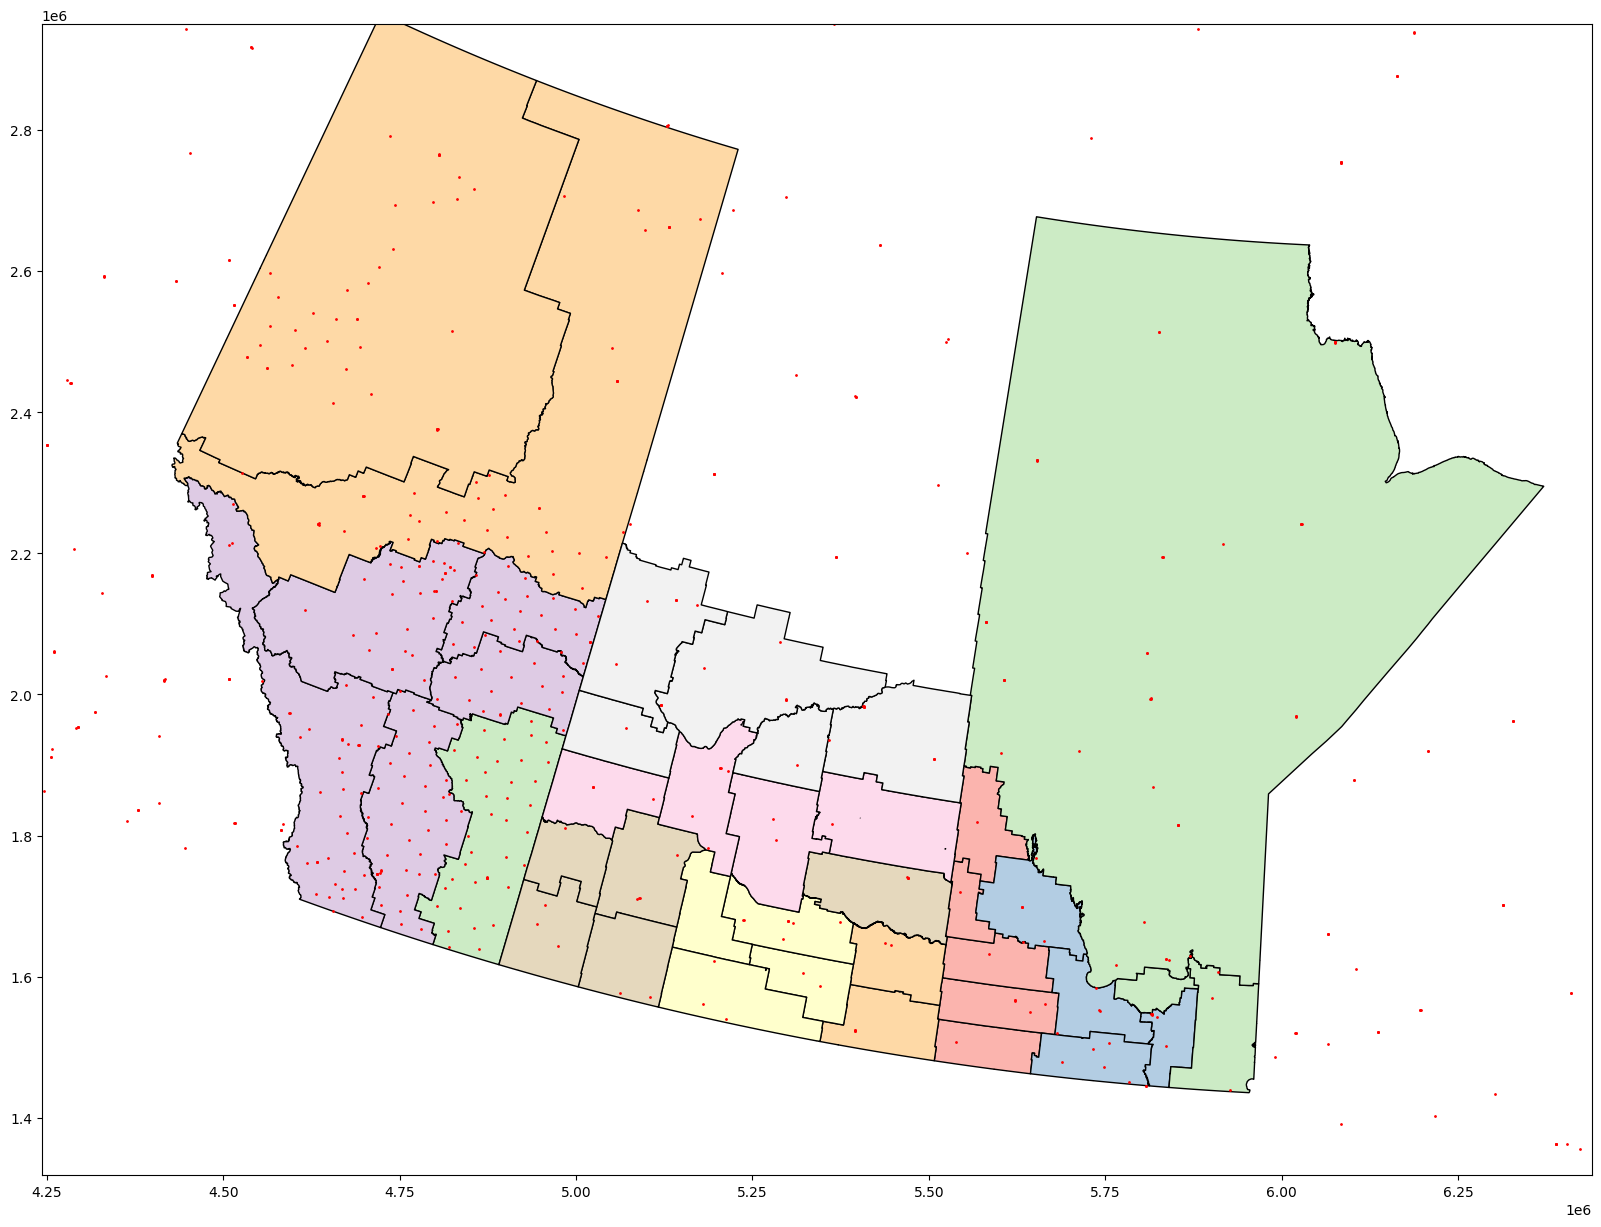

In [16]:
# plot stations vs projected regions
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny * 2, maxy / 1.2)
ax.set_xlim(minx * 1.15, maxx / 1.4)
gdfProjected.plot(ax=ax, cmap="Pastel1", edgecolor="black")
gdfStationsDly.plot(ax=ax, color="red", markersize=1)

In [17]:
gdfStationsDly.count()

Station Name      1608
Province          1608
Latitude          1608
Longitude         1608
Elevation         1608
Climate ID        1608
WMO Identifier    1057
TC Identifier     1536
First Year        1608
Last Year         1608
HLY First Year    1608
HLY Last Year     1608
DLY First Year    1518
DLY Last Year     1518
MLY First Year     826
MLY Last Year      826
geometry          1608
dtype: int64

In [18]:
# reindex
gdfProjected.reset_index(inplace=True)

In [19]:
gdfProjected

,index,CARuid,CARname,PRuid,AGuid,geometry
0,34,4601,Census Agricultural Region 1,46,460100000,"POLYGON ((5614040.030 1525793.204, 5614049.916..."
1,35,4602,Census Agricultural Region 2,46,460200000,"POLYGON ((5626194.299 1583517.983, 5626196.761..."
2,36,4603,Census Agricultural Region 3,46,460300000,"POLYGON ((5604868.041 1657581.280, 5604597.366..."
3,37,4604,Census Agricultural Region 4,46,460400000,"POLYGON ((5572893.654 1735557.501, 5572702.245..."
4,38,4605,Census Agricultural Region 5,46,460500000,"POLYGON ((5642129.777 1764975.307, 5640570.825..."
5,39,4606,Census Agricultural Region 6,46,460600000,"POLYGON ((5650771.936 1802331.590, 5650891.341..."
6,40,4607,Census Agricultural Region 7,46,460700000,"POLYGON ((5699696.737 1638839.856, 5699169.985..."
7,41,4608,Census Agricultural Region 8,46,460800000,"POLYGON ((5811211.812 1504579.905, 5813077.828..."
8,42,4609,Census Agricultural Region 9,46,460900000,"POLYGON ((5881996.131 1582644.382, 5881995.457..."
9,43,4610,Census Agricultural Region 10,46,461000000,"MULTIPOLYGON (((5963272.940 1505971.912, 59632..."


In [20]:
# gray in rgba
gdfProjected["color"] = "#808080"

In [21]:
gdfProjected["CRnum"] = 0

In [22]:
# list of 11 colors complimentary in rgba
colors = [
    "#d3d3d3",
    "#556b2f",
    "#008080",
    "#6495ed",
    "#00ff7f",
    "#db7093",
    "#f0e68c",
    "#ffa07a",
    "#ee82ee",
    "#1e90ff",
    "#eee8aa",
]

In [23]:
gdfProjected["CARuid"] = gdfProjected["CARuid"].astype(int)

In [24]:
gdfProjected.loc[
    gdfProjected["CARuid"].isin([4612, 4601, 4602, 4603, 4608]), "CRnum"
] = 3
gdfProjected.loc[gdfProjected["CARuid"].isin([4604, 4605, 4606]), "CRnum"] = 2
gdfProjected.loc[gdfProjected["CARuid"].isin([4607, 4609, 4610, 4611]), "CRnum"] = 1

gdfProjected.loc[gdfProjected["CRnum"] == 3, "color"] = colors[0]
gdfProjected.loc[gdfProjected["CRnum"] == 2, "color"] = colors[1]
gdfProjected.loc[gdfProjected["CRnum"] == 1, "color"] = colors[2]

In [25]:
gdfProjected.loc[gdfProjected["CARuid"].isin([4810, 4820, 4830]), "CRnum"] = 8
gdfProjected.loc[gdfProjected["CARuid"].isin([4840, 4841, 4850]), "CRnum"] = 9
gdfProjected.loc[gdfProjected["CARuid"].isin([4860, 4870]), "CRnum"] = 10

gdfProjected.loc[gdfProjected["CRnum"] == 8, "color"] = colors[3]
gdfProjected.loc[gdfProjected["CRnum"] == 9, "color"] = colors[4]
gdfProjected.loc[gdfProjected["CRnum"] == 10, "color"] = colors[10]

In [26]:
gdfProjected.loc[
    gdfProjected["CARuid"].isin([4710, 4711, 4720, 4721, 4731]), "CRnum"
] = 4
gdfProjected.loc[
    gdfProjected["CARuid"].isin([4730, 4732, 4733, 4740, 4741]), "CRnum"
] = 5
gdfProjected.loc[
    gdfProjected["CARuid"].isin([4750, 4751, 4760, 4780, 4781]), "CRnum"
] = 6
gdfProjected.loc[
    gdfProjected["CARuid"].isin([4761, 4770, 4771, 4790, 4791]), "CRnum"
] = 7


gdfProjected.loc[gdfProjected["CRnum"] == 4, "color"] = colors[5]
gdfProjected.loc[gdfProjected["CRnum"] == 5, "color"] = colors[7]
gdfProjected.loc[gdfProjected["CRnum"] == 6, "color"] = colors[6]
gdfProjected.loc[gdfProjected["CRnum"] == 7, "color"] = colors[8]

<Axes: >

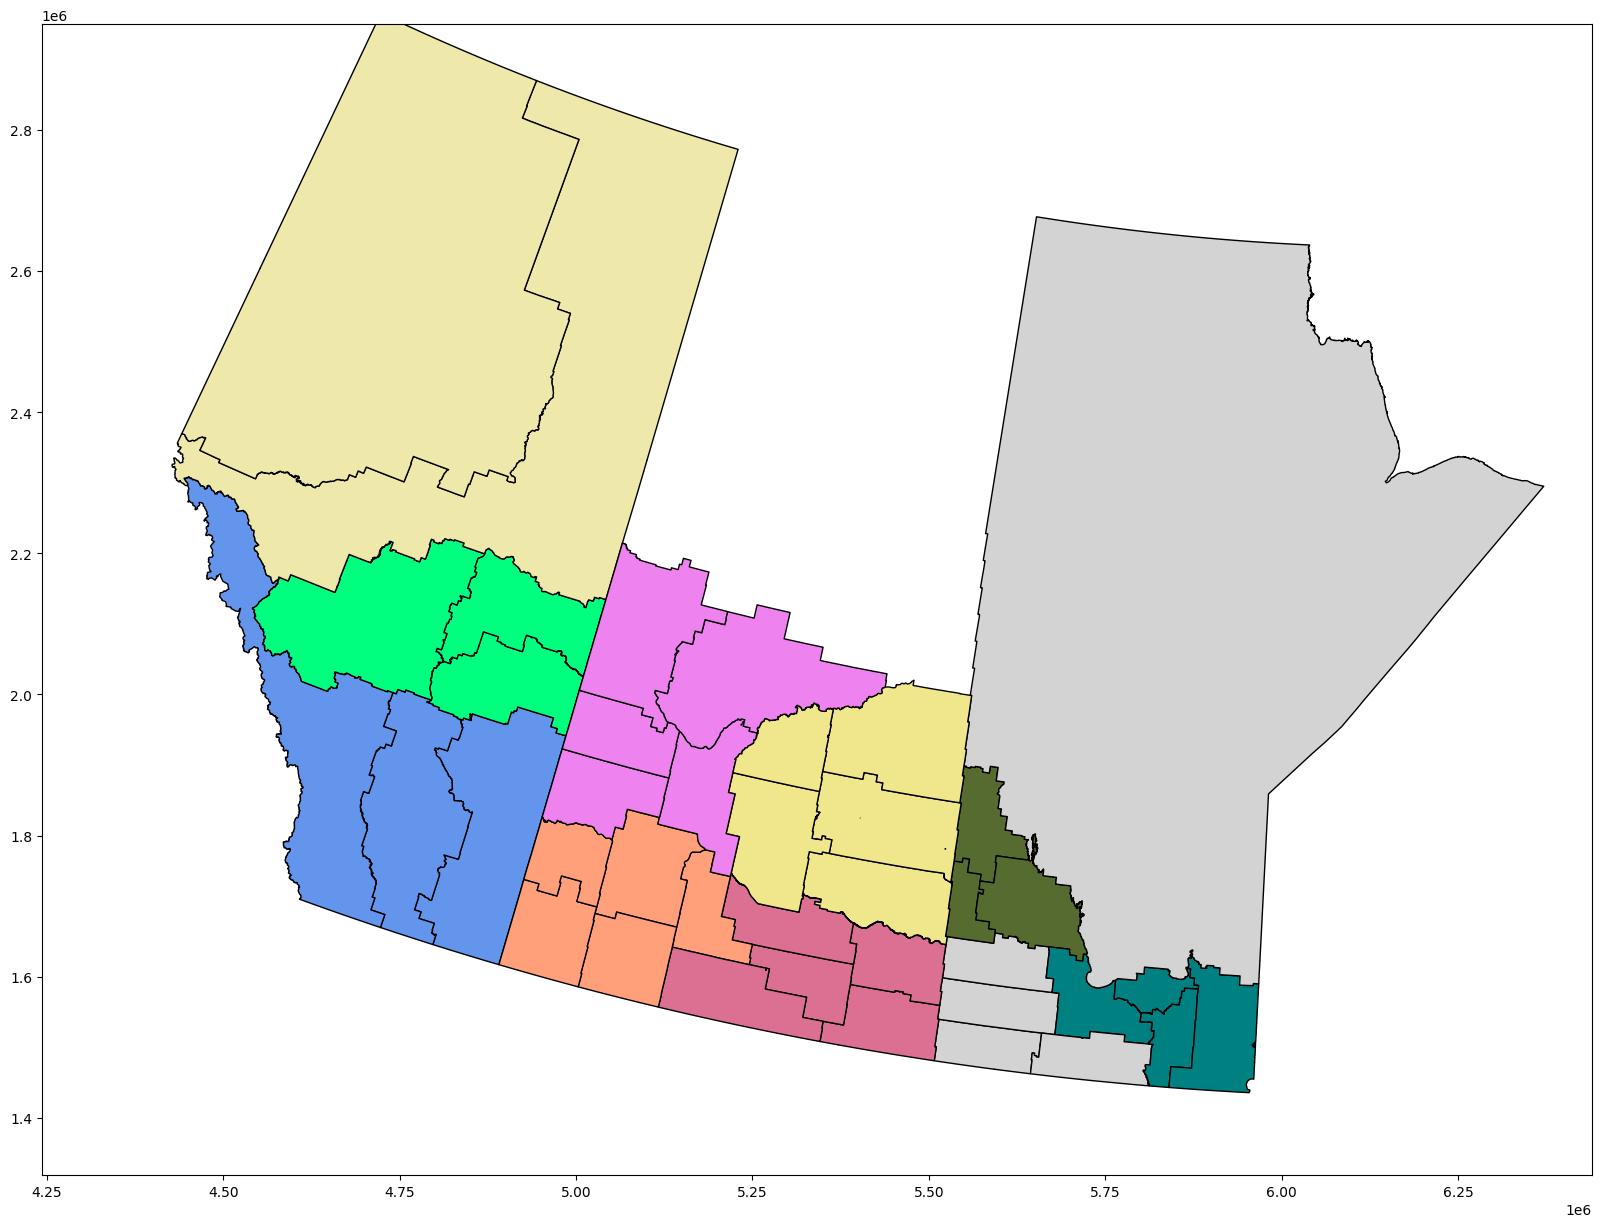

In [27]:
# plot using color column
fig, ax = plt.subplots(figsize=(20, 20))
ax.set_ylim(miny * 2, maxy / 1.2)
ax.set_xlim(minx * 1.15, maxx / 1.4)
gdfProjected.plot(ax=ax, color=gdfProjected["color"], edgecolor="black")

In [28]:
# now the regions and stations are in the same projection
# the regions dataframe has a column called 'color' that has the color for each region and the number of the CR
# we will now add a column to the stations list for the CR number
# first we only keep ALBERTA MANITOBA SASKATCHEWAN in Province column from gdfStationsDly
gdfStationsDly = gdfStationsDly[
    gdfStationsDly["Province"].isin(["ALBERTA", "MANITOBA", "SASKATCHEWAN"])
]

gdfStationsDly = gdfStationsDly.sjoin(gdfProjected, how="left", op="within")
# gdfStationsDly
gdfStationsDly.drop(
    columns=["index_right", "index", "CARname", "PRuid", "AGuid", "color"], inplace=True
)
gdfStationsDly.rename(columns={"CARuid": "district"}, inplace=True)

In [ ]:
# we do the same for gdfStationsHly
gdfStationsHly = gdfStationsHly[
    gdfStationsHly["Province"].isin(["ALBERTA", "MANITOBA", "SASKATCHEWAN"])
]
gdfStationsHly = gdfStationsHly.sjoin(gdfProjected, how="left", op="within")
# gdfStationsHly
gdfStationsHly.drop(
    columns=["index_right", "index", "CARname", "PRuid", "AGuid", "color"], inplace=True
)
gdfStationsHly.rename(columns={"CARuid": "district"}, inplace=True)

In [ ]:
# gdfStationsDly.head()
# print unique CR numbers
# gdfProjected["CRnum"].unique()
# print rows with CRnum = 0
# gdfProjected[gdfProjected["CRnum"] == 0]

,Station Name,Province,Latitude,Longitude,Elevation,Climate ID,WMO Identifier,TC Identifier,First Year,Last Year,HLY First Year,HLY Last Year,DLY First Year,DLY Last Year,MLY First Year,MLY Last Year,geometry,district,CRnum
19,ABEE AGDM,ALBERTA,54.3,-113.0,664.0,3010010,71285.0,XAF,1990,2023,1990.0,2023.0,2002.0,2023.0,2002.0,2007.0,POINT (4873611.671 2233163.584),4860.0,10.0
32,ACADIA VALLEY,ALBERTA,51.1,-110.3,735.0,3020035,71048.0,PAC,2009,2023,2009.0,2023.0,2009.0,2023.0,NaN,NaN,POINT (4934211.186 1843262.910),4810.0,8.0
77,ALBERT HALL AGCM,ALBERTA,53.1,-111.2,658.0,3010060,71005.0,PAH,2007,2023,2007.0,2023.0,2007.0,2023.0,2007.0,2007.0,POINT (4944138.661 2075032.990),4840.0,9.0
120,ALLIANCE AGCM,ALBERTA,52.3,-111.8,737.0,3010162,71006.0,PAA,2007,2023,2007.0,2023.0,2007.0,2023.0,2007.0,2007.0,POINT (4879655.569 2004484.102),4840.0,9.0
166,ANDREW AGDM,ALBERTA,53.9,-112.3,625.0,3010237,71286.0,XAG,1998,2023,1998.0,2023.0,2002.0,2023.0,2002.0,2007.0,POINT (4903023.739 2181609.929),4841.0,9.0


In [41]:
# add column 'scraped' to gdfStationsDly and gdfStationsHly and set it to false
gdfStationsDly["scraped"] = False
gdfStationsHly["scraped"] = False

In [42]:
# remove index column from gdfProjected
gdfProjected = gdfProjected.drop(columns=["index"])

# reindex gdfProjected gdfStationsDly gdfStationsHly
gdfProjected = gdfProjected.reset_index(drop=True)
gdfStationsDly = gdfStationsDly.reset_index(drop=True)
gdfStationsHly = gdfStationsHly.reset_index(drop=True)

In [43]:
def pushGdfToPostGresDB(
    tableName: str,
    geodf: gpd.GeoDataFrame,
    db: str,
    addr: str,
    port: int,
    user: str,
    pw: str,
) -> None:
    
    if (
        db is None
        or addr is None
        or port is None
        or user is None
        or pw is None
    ):
        raise ValueError("Environment variables not set")

    db_service = DataService(db, addr, port, user, pw)
    db_con = db_service.connect()

    geodf.to_postgis(tableName, db_con, index=False, if_exists="replace")
    db_service.cleanup()

In [44]:
gdfProjected.rename(columns={"CARuid": "car_uid"}, inplace=True)
gdfProjected.rename(columns={"CARname": "car_name"}, inplace=True)
gdfProjected.rename(columns={"PRuid": "pr_uid"}, inplace=True)
gdfProjected.rename(columns={"AGuid": "ag_uid"}, inplace=True)

In [45]:
gdfStationsDly.rename(columns={"Station Name": "station_name"}, inplace=True)
gdfStationsDly.rename(columns={"Province": "province"}, inplace=True)
gdfStationsDly.rename(columns={"Latitude": "latitude"}, inplace=True)
gdfStationsDly.rename(columns={"Longitude": "longitude"}, inplace=True)
gdfStationsDly.rename(columns={"Elevation": "elevation"}, inplace=True)
gdfStationsDly.rename(columns={"Climate ID": "station_id"}, inplace=True)
gdfStationsDly.rename(columns={"WMO Identifier": "wmo_identifier"}, inplace=True)
gdfStationsDly.rename(columns={"TC Identifier": "tc_identifier"}, inplace=True)
gdfStationsDly.rename(columns={"First Year": "first_year"}, inplace=True)
gdfStationsDly.rename(columns={"Last Year": "last_year"}, inplace=True)
gdfStationsDly.rename(columns={"HLY First Year": "hly_first_year"}, inplace=True)
gdfStationsDly.rename(columns={"HLY Last Year": "hly_last_year"}, inplace=True)
gdfStationsDly.rename(columns={"DLY First Year": "dly_first_year"}, inplace=True)
gdfStationsDly.rename(columns={"DLY Last Year": "dly_last_year"}, inplace=True)
gdfStationsDly.rename(columns={"MLY First Year": "mly_first_year"}, inplace=True)
gdfStationsDly.rename(columns={"MLY Last Year": "mly_last_year"}, inplace=True)
# gdfStationsDly.rename(columns={gdfStationsDly.columns[16]: "geometry"}, inplace=True)
gdfStationsDly.rename(columns={"CRnum": "cr_num"}, inplace=True)

gdfStationsDly.loc[gdfStationsDly["province"] == "ALBERTA", "province"] = "AB"
gdfStationsDly.loc[gdfStationsDly["province"] == "MANITOBA", "province"] = "MB"
gdfStationsDly.loc[gdfStationsDly["province"] == "SASKATCHEWAN", "province"] = "SK"

In [46]:
gdfStationsHly.rename(columns={"Station Name": "station_name"}, inplace=True)
gdfStationsHly.rename(columns={"Province": "province"}, inplace=True)
gdfStationsHly.rename(columns={"Latitude": "latitude"}, inplace=True)
gdfStationsHly.rename(columns={"Longitude": "longitude"}, inplace=True)
gdfStationsHly.rename(columns={"Elevation": "elevation"}, inplace=True)
gdfStationsHly.rename(columns={"Climate ID": "station_id"}, inplace=True)
gdfStationsHly.rename(columns={"WMO Identifier": "wmo_identifier"}, inplace=True)
gdfStationsHly.rename(columns={"TC Identifier": "tc_identifier"}, inplace=True)
gdfStationsHly.rename(columns={"First Year": "first_year"}, inplace=True)
gdfStationsHly.rename(columns={"Last Year": "last_year"}, inplace=True)
gdfStationsHly.rename(columns={"HLY First Year": "hly_first_year"}, inplace=True)
gdfStationsHly.rename(columns={"HLY Last Year": "hly_last_year"}, inplace=True)
gdfStationsHly.rename(columns={"DLY First Year": "dly_first_year"}, inplace=True)
gdfStationsHly.rename(columns={"DLY Last Year": "dly_last_year"}, inplace=True)
gdfStationsHly.rename(columns={"MLY First Year": "mly_first_year"}, inplace=True)
gdfStationsHly.rename(columns={"MLY Last Year": "mly_last_year"}, inplace=True)
# gdfStationsHly.rename(columns={gdfStationsDly.columns[16]: "geometry"}, inplace=True)
gdfStationsHly.rename(columns={"CRnum": "cr_num"}, inplace=True)

gdfStationsHly.loc[gdfStationsHly["province"] == "ALBERTA", "province"] = "AB"
gdfStationsHly.loc[gdfStationsHly["province"] == "MANITOBA", "province"] = "MB"
gdfStationsHly.loc[gdfStationsHly["province"] == "SASKATCHEWAN", "province"] = "SK"

# change next cell to code to push to DB

In [47]:
### push dataframes to postgres

if (
    PG_DB is None
    or PG_ADDR is None
    or PG_PORT is None
    or PG_USER is None
    or PG_PW is None
):
    raise ValueError("Environment variables not set")
    
tblName = "census_ag_regions"
pushGdfToPostGresDB(tblName, gdfProjected, PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)

tblName = "stations_dly"
pushGdfToPostGresDB(tblName, gdfStationsDly, PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)

tblName = "stations_hly"
pushGdfToPostGresDB(tblName, gdfStationsHly, PG_DB, PG_ADDR, int(PG_PORT), PG_USER, PG_PW)